In [1]:
from models.dataset import *
from models.discriminator import *
from models.inverter import *
from models.args import *

In [2]:
graphs = get_dataset("ENZYMES")
args = Args()
train_loader = get_dataloader_train(graphs, args)

Extracting ../data/TUDataset/ENZYMES/ENZYMES.zip
Processing...
Done!


In [3]:
len(graphs)

600

In [4]:
# for i, data in enumerate(train_loader):
#     print(data.keys())
#     # X = data['x']
#     # Y = data['y']
#     # print(X.shape)
#     # print(Y.shape)
#     # print(data['len'])
#     break

In [5]:
I = Inverter(input_dim=512, output_dim=8, hidden_dim=256)
D = NetD(stat_input_dim=128, stat_hidden_dim=64, num_stat=2)

In [7]:
optimizerI = optim.Adam(I.parameters(), lr=1e-3)
lossI = WGAN_ReconLoss(0.1, 'MSE')
optimizerD = optim.Adam(D.parameters(), lr=1e-3, betas=[1e-5 for _ in range(2)])

In [10]:
# noise = torch.randn(64, 8).to('cuda')
noise = torch.randn(64, 8)
one = torch.FloatTensor([1])
mone = one * -1

X = graphs[0]
Diters = 10 # number of iterations to train discriminator
j = 0
while j < Diters:
    j += 1
    # weight clipping: clamp parameters to a cube
    for p in D.parameters():
        p.data.clamp_(-0.01, 0.01)
    D.zero_grad()

    # train with real
    errD_real = D(X)
    errD_real.backward(one) # discriminator should assign 1's to true samples
    optimizerD.step()

TypeError: histogram() received an invalid combination of arguments - got (numpy.ndarray, density=bool, range=tuple, bins=int), but expected one of:
 * (Tensor input, Tensor bins, *, Tensor weight, bool density, tuple of Tensors out)
 * (Tensor input, int bins, *, tuple of floats range, Tensor weight, bool density, tuple of Tensors out)


In [10]:
errD_real

tensor([-0.0031], grad_fn=<TanhBackward0>)

In [11]:
n = graphs[0].number_of_nodes()
s = nx.number_strongly_connected_components(graphs[0])
v = s+1
p_in = min(graphs[0].number_of_edges()/graphs[0].number_of_nodes(), 0.9)
p_out = min(s**3/graphs[0].number_of_nodes(), 0.4)

nx.gaussian_random_partition_graph(n,s,v,p_in,p_out)
# nx.draw(graphs[0], with_labels=True)
# nx.is_directed(graphs[0])

In [32]:
one = torch.FloatTensor([1])
mone = one * -1
errDs = []

for p in D.parameters(): # reset requires_grad
    p.requires_grad = True

for i, data in enumerate(graphs):
    X = data
    Diters = 5 # number of iterations to train discriminator
    j = 0 # counter for 1, 2, ... Diters
    while j < Diters:
        j += 1
        # weight clipping: clamp parameters to a cube
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)
        D.zero_grad()

        # train with real
        errD_real = D(X)
        errD_real.backward(one) # discriminator should assign 1's to true samples

        # train with fake
        n = X.number_of_nodes()
        s = nx.number_strongly_connected_components(X)
        v = s+1
        p_in = min(X.number_of_edges()/X.number_of_nodes(), 0.9)
        p_out = min(s**3/X.number_of_nodes(), 0.4)
        noise_graph = nx.gaussian_random_partition_graph(n,s,v,p_in,p_out)
        
        # insert data processing
        # fake = D(input)
        errD_fake = D(noise_graph)
        errD_fake.backward(mone) # discriminator should assign -1's to fake samples??

        # compute Wasserstein distance and update parameters
        errD = errD_real - errD_fake
        optimizerD.step()

    errDs.append(errD.detach().numpy()[0])

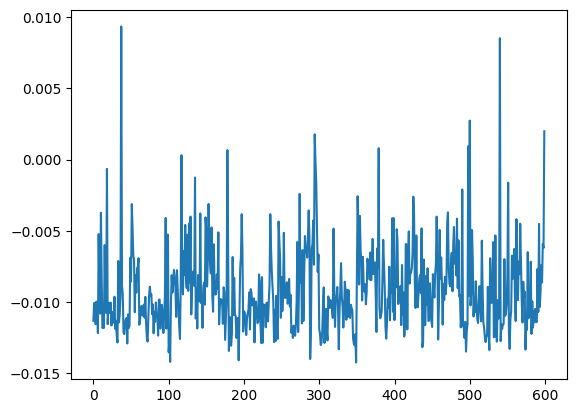

In [33]:
plt.plot(errDs)
# errDs